In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings

## Import data

In [17]:
churn_df= pd.read_csv("../raw_data/churn_df_underbalanced.csv")

In [18]:
data_df = churn_df

In [19]:
data_df = data_df.drop(['Unnamed: 0','msno'], axis=1)

In [20]:
scale_features = ['payment_method_id',
                  'payment_plan_days',
                  'plan_list_price',
                  'actual_amount_paid',
                  'remaining_plan_duration',
                  'num_25',
                  'num_50',
                  'num_75',
                  'num_985',
                  'num_100',
                  'num_unq',
                  'total_secs',
                  'city',
                  'bd',
                  'registered_via', 'usage_from_ltd']

## Pipeline start

In [21]:
# Build the pipeline with the different steps
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())

preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, scale_features)],
    remainder='passthrough'
)


In [22]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['payment_method_id', 'payment_plan_days',
                                  'plan_list_price', 'actual_amount_paid',
                                  'remaining_plan_duration', 'num_25', 'num_50',
                                  'num_75', 'num_985', 'num_100', 'num_unq',
                                  'total_secs', 'city', 'bd', 'registered_via',
                                  'usage_from_ltd'])])

In [23]:
#create X and y
X = data_df.drop(['is_churn'], axis=1)
y= data_df['is_churn']

In [24]:
# Use fit on X_train and then transform both datasets
preprocessor.fit(X)
X_train_transformed = preprocessor.transform(X)

In [25]:
# Convert transformed data back to DataFrame to ensure column order is maintained
X_train_transformed = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
)

# X_val_transformed = pd.DataFrame(
#     X_val_transformed, 
#     columns=preprocessor.get_feature_names_out()
# )


In [29]:
xgb_clas = XGBClassifier()

cv_results = cross_validate(xgb_clas, X_train_transformed, y, cv=5)

accuracy = cv_results['test_score'].mean()

warnings.filterwarnings('ignore', category=FutureWarning)

In [30]:
cv_results

{'fit_time': array([2.84417796, 2.83588076, 2.87022376, 2.87334704, 2.91501784]),
 'score_time': array([0.00894785, 0.01044822, 0.01133204, 0.01278305, 0.01093411]),
 'test_score': array([0.96795521, 0.96593007, 0.96974029, 0.96968072, 0.96622588])}

In [31]:
accuracy

0.9679064345332138

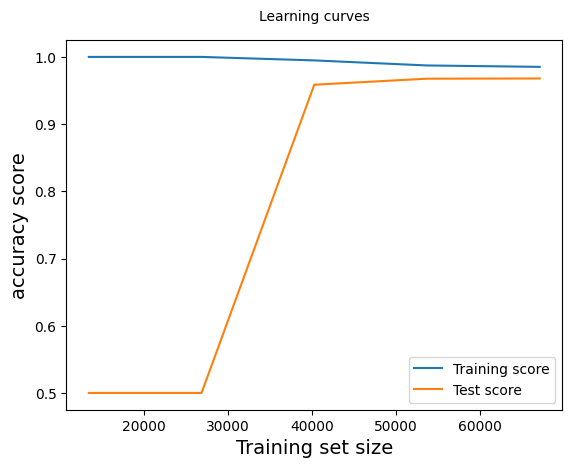

In [33]:
#learning curves for all features

train_sizes = np.linspace(0.2,1,5)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBClassifier(), 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
#plt.ylim(0,1)
plt.legend()

warnings.filterwarnings('ignore', category=FutureWarning)

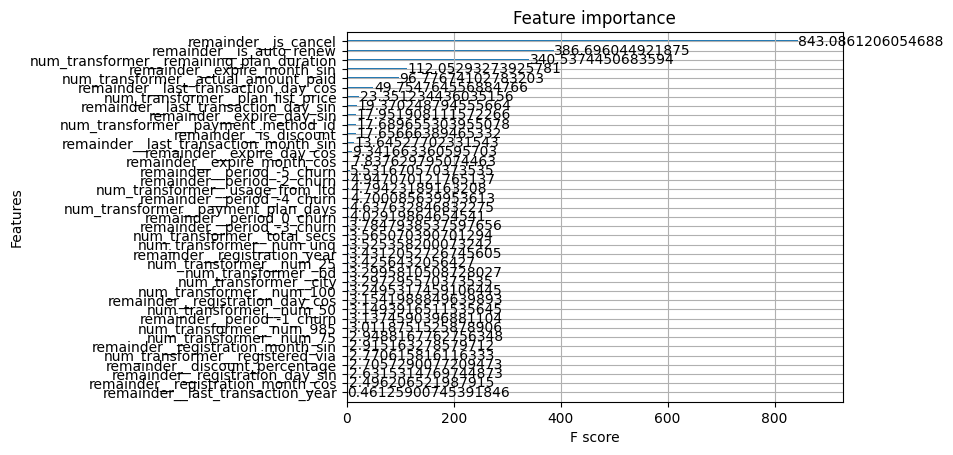

In [26]:
#feature importance 
xgb_clas.fit(X_train_transformed, y)
plot_importance(xgb_clas, importance_type='gain')
plt.show()

In [27]:
#take only top 15 features
importances = xgb_clas.feature_importances_
feature_names = X_train_transformed.columns

sorted_indices = np.argsort(importances)[::-1] 

top_15_features = feature_names[sorted_indices[:15]]

X_train_transformed_top_15 = X_train_transformed[top_15_features]



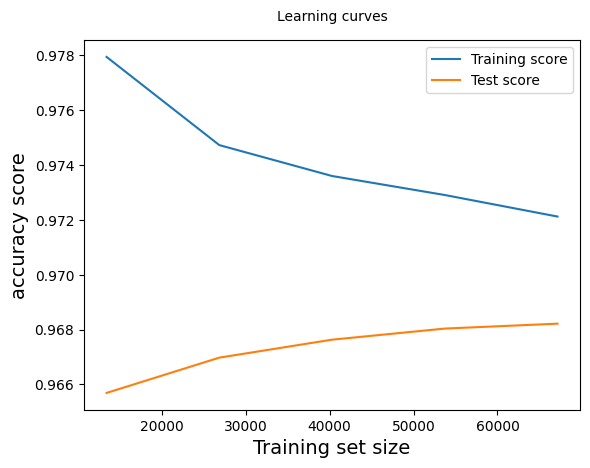

In [28]:
#learning curves with top 15 features

train_sizes = np.linspace(0.2,1,10)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBClassifier(), 
    X=X_train_transformed_top_15, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
#plt.ylim(0,1)
plt.legend()

warnings.filterwarnings('ignore', category=FutureWarning)

In [34]:
#Top 5 features 
top_5_features = feature_names[sorted_indices[:5]]

X_train_transformed_top_5 = X_train_transformed[top_5_features]



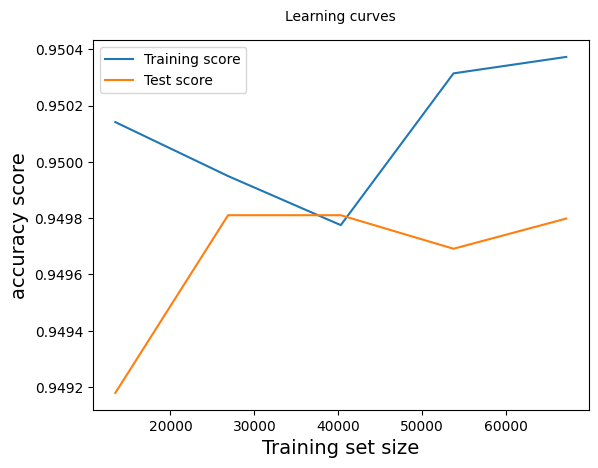

In [36]:
#learning curves with top 5 features

train_sizes = np.linspace(0.2,1,5)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBClassifier(), 
    X=X_train_transformed_top_5, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
#plt.ylim(0,1)
plt.legend()

warnings.filterwarnings('ignore', category=FutureWarning)